# EDA & Budget selection

In [36]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

import matplotlib.pyplot as plt

In [37]:
pd.set_option('display.float_format', '{:.6f}'.format)


initial config file to config_dict

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/config ups ca.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

06.04.2024


Query Daily Data

In [4]:
daily_df = GetBQData(training_query, _input, _output)
daily_df.ds = pd.to_datetime(daily_df.ds) # ensure ds is date_time type
daily_df['day'] = daily_df.ds.dt.day
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [5]:
daily_df

,region,market,account_type,funnel,ds,X,y,day,month,year
0,Canada,Canada,Bing Ads,Brand,2018-03-05,71.040000,18.000000,5,3,2018
1,Canada,Canada,Bing Ads,Brand,2018-03-06,69.000000,25.000000,6,3,2018
2,Canada,Canada,Bing Ads,Brand,2018-03-07,59.310001,21.000000,7,3,2018
3,Canada,Canada,Bing Ads,Brand,2018-03-08,57.739999,34.000000,8,3,2018
4,Canada,Canada,Bing Ads,Brand,2018-03-09,32.580000,20.000000,9,3,2018
...,...,...,...,...,...,...,...,...,...,...
13312,Canada,Canada,Google AdWords,Generic,2024-05-30,164.820000,46.000000,30,5,2024
13313,Canada,Canada,Google AdWords,Generic,2024-05-31,37.240000,41.000000,31,5,2024
13314,Canada,Canada,Google AdWords,Generic,2024-06-01,25.180000,0.000000,1,6,2024
13315,Canada,Canada,Google AdWords,Generic,2024-06-02,22.040000,0.000000,2,6,2024


In [6]:
year_2022 = daily_df.loc[(daily_df['ds'] >= '2022-04-28') & (daily_df['ds'] <= '2022-06-04'), 'X'].sum()
year_2023 = daily_df.loc[(daily_df['ds'] >= '2023-04-27') & (daily_df['ds'] <= '2023-06-03'), 'X'].sum()
pre_optimization_budget = (year_2022 + year_2023) / 2

In [7]:
pre_optimization_budget

55778.5

In [8]:
df = daily_df.copy()

In [30]:
df

,region,market,account_type,funnel,ds,X,y,day,month,year
0,Canada,Canada,Bing Ads,Brand,2018-03-05,71.040000,18.000000,5,3,2018
1,Canada,Canada,Bing Ads,Brand,2018-03-06,69.000000,25.000000,6,3,2018
2,Canada,Canada,Bing Ads,Brand,2018-03-07,59.310001,21.000000,7,3,2018
3,Canada,Canada,Bing Ads,Brand,2018-03-08,57.739999,34.000000,8,3,2018
4,Canada,Canada,Bing Ads,Brand,2018-03-09,32.580000,20.000000,9,3,2018
...,...,...,...,...,...,...,...,...,...,...
13228,Canada,Canada,Google AdWords,Generic,2024-05-16,53.350000,26.000000,16,5,2024
13229,Canada,Canada,Google AdWords,Generic,2024-05-17,37.010000,21.000000,17,5,2024
13230,Canada,Canada,Google AdWords,Generic,2024-05-18,23.560000,0.000000,18,5,2024
13231,Canada,Canada,Google AdWords,Generic,2024-05-19,21.600000,0.000000,19,5,2024


In [9]:
df['region'] = 'North America' 

In [10]:
df.loc[df['funnel'] != 'Brand', 'funnel'] = 'Non_Brand'

In [11]:
df

,region,market,account_type,funnel,ds,X,y,day,month,year
0,North America,Canada,Bing Ads,Brand,2018-03-05,71.040000,18.000000,5,3,2018
1,North America,Canada,Bing Ads,Brand,2018-03-06,69.000000,25.000000,6,3,2018
2,North America,Canada,Bing Ads,Brand,2018-03-07,59.310001,21.000000,7,3,2018
3,North America,Canada,Bing Ads,Brand,2018-03-08,57.739999,34.000000,8,3,2018
4,North America,Canada,Bing Ads,Brand,2018-03-09,32.580000,20.000000,9,3,2018
...,...,...,...,...,...,...,...,...,...,...
13312,North America,Canada,Google AdWords,Non_Brand,2024-05-30,164.820000,46.000000,30,5,2024
13313,North America,Canada,Google AdWords,Non_Brand,2024-05-31,37.240000,41.000000,31,5,2024
13314,North America,Canada,Google AdWords,Non_Brand,2024-06-01,25.180000,0.000000,1,6,2024
13315,North America,Canada,Google AdWords,Non_Brand,2024-06-02,22.040000,0.000000,2,6,2024


In [12]:
df = df.groupby(['region', 'market', 'funnel', 'ds','day','month','year'])[['X', 'y']].sum().reset_index()

In [35]:
df

,region,market,funnel,ds,day,month,year,X,y
0,North America,Canada,Brand,2017-08-10,10,8,2017,1241.550012,555.000000
1,North America,Canada,Brand,2017-08-11,11,8,2017,995.119990,442.000000
2,North America,Canada,Brand,2017-08-12,12,8,2017,0.000000,12.000000
3,North America,Canada,Brand,2017-08-13,13,8,2017,0.000000,3.000000
4,North America,Canada,Brand,2017-08-14,14,8,2017,998.350000,413.000000
...,...,...,...,...,...,...,...,...,...
4832,North America,Canada,Non_Brand,2024-05-16,16,5,2024,437.650000,92.000000
4833,North America,Canada,Non_Brand,2024-05-17,17,5,2024,423.810000,77.000000
4834,North America,Canada,Non_Brand,2024-05-18,18,5,2024,193.270000,1.000000
4835,North America,Canada,Non_Brand,2024-05-19,19,5,2024,205.820000,1.000000


In [13]:
# remove rows without date or conversion quantity
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

In [14]:
df

,region,market,funnel,ds,day,month,year,X,y
0,North America,Canada,Brand,2017-08-10,10,8,2017,1241.550012,555.000000
1,North America,Canada,Brand,2017-08-11,11,8,2017,995.119990,442.000000
2,North America,Canada,Brand,2017-08-12,12,8,2017,0.000000,12.000000
3,North America,Canada,Brand,2017-08-13,13,8,2017,0.000000,3.000000
4,North America,Canada,Brand,2017-08-14,14,8,2017,998.350000,413.000000
...,...,...,...,...,...,...,...,...,...
4860,North America,Canada,Non_Brand,2024-05-30,30,5,2024,376.440000,88.000000
4861,North America,Canada,Non_Brand,2024-05-31,31,5,2024,203.780000,83.000000
4862,North America,Canada,Non_Brand,2024-06-01,1,6,2024,119.380000,0.000000
4863,North America,Canada,Non_Brand,2024-06-02,2,6,2024,109.040000,1.000000


In [11]:
#df.to_csv('df.csv', index=False)

### Plot CA historical Data 

In [30]:
df_plot = df.copy()
df_plot['year_month'] = df_plot.ds.dt.strftime('%Y-%m')
df_plot = df_plot.groupby(['market','year_month']).sum(numeric_only=True).reset_index()
df_plot = df_plot.loc[(df_plot['year_month'] >= '2023-01') & (df_plot['year_month'] <= '2024-04')]
df_plot

,market,year_month,day,month,year,X,y
64,Canada,2023-01,992,62,125426,48955.410000,29437.000000
65,Canada,2023-02,812,112,113288,47758.260000,28186.000000
66,Canada,2023-03,992,186,125426,56633.780000,31889.000000
67,Canada,2023-04,930,240,121380,51876.770000,27717.000000
68,Canada,2023-05,992,310,125426,38338.640000,29669.000000
69,Canada,2023-06,930,360,121380,60485.880000,27044.000000
70,Canada,2023-07,992,434,125426,59791.000000,28219.000000
71,Canada,2023-08,992,496,125426,55780.770000,25153.000000
72,Canada,2023-09,930,540,121380,52990.110000,21088.000000
73,Canada,2023-10,992,620,125426,79091.186400,20378.000000


/var/tmp/ipykernel_21921/2426380421.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_plot['year_month'].dt.strftime('%Y-%m'), rotation=45, ha='right')


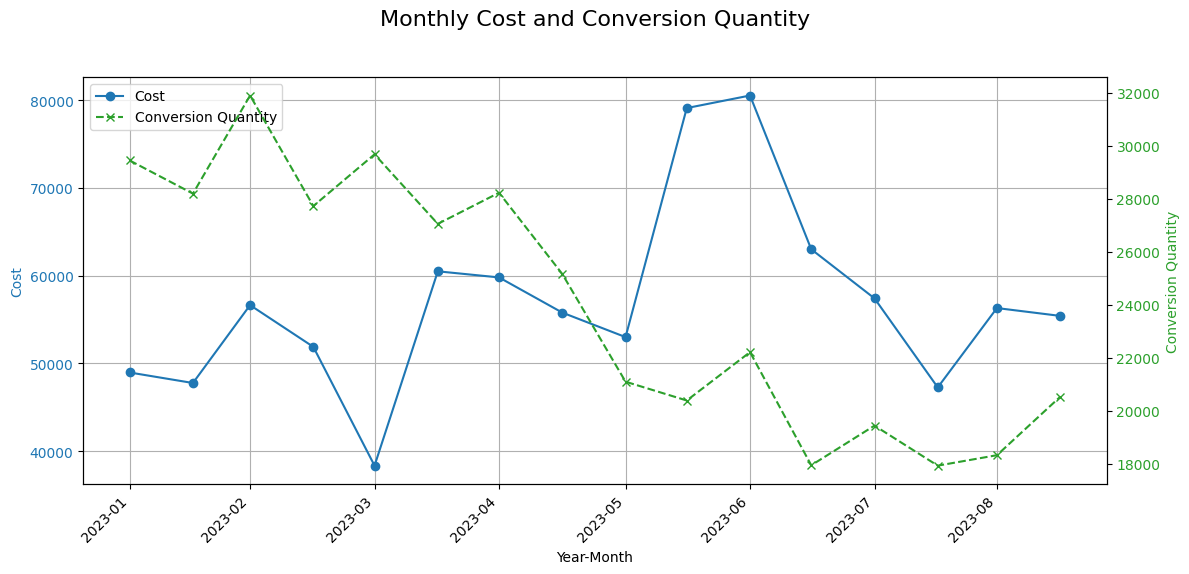

In [33]:
df_plot['year_month'] = pd.to_datetime(df_plot['year_month'], format='%Y-%m')
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar 'Cost' en el primer eje
color = 'tab:blue'
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color=color)
ax1.plot(df_plot['year_month'], df_plot['X'], color=color, linestyle='-', marker='o', label='Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(df_plot['year_month'].dt.strftime('%Y-%m'), rotation=45, ha='right')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion Quantity', color=color)
ax2.plot(df_plot['year_month'], df_plot['y'], color=color, linestyle='--', marker='x', label='Conversion Quantity')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título y ajustar el layout
fig.suptitle('Monthly Cost and Conversion Quantity', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Añadir leyendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

/var/tmp/ipykernel_21921/1651745625.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_plot['year_month'].dt.strftime('%Y-%m'), rotation=45, ha='right')


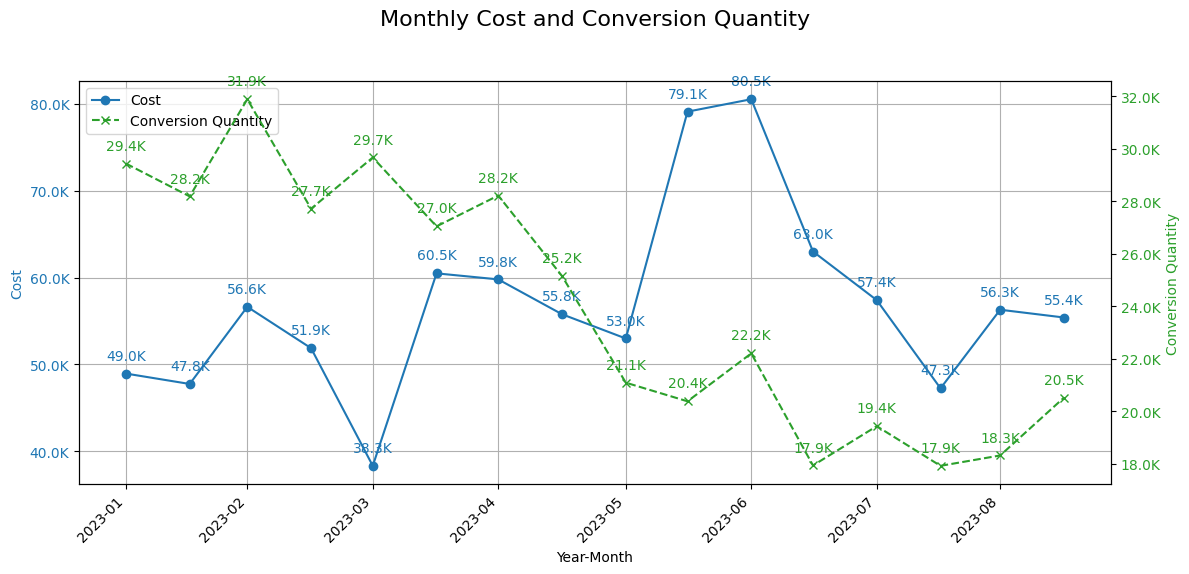

In [35]:
def format_value(val):
    if val >= 1000:
        return f'{val/1000:.1f}K'
    return str(val)

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar 'Cost' en el primer eje
color = 'tab:blue'
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color=color)
ax1.plot(df_plot['year_month'], df_plot['X'], color=color, linestyle='-', marker='o', label='Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(df_plot['year_month'].dt.strftime('%Y-%m'), rotation=45, ha='right')
ax1.grid(True)

# Añadir anotaciones para 'Cost'
for i, value in enumerate(df_plot['X']):
    ax1.annotate(format_value(value), (df_plot['year_month'].iloc[i], df_plot['X'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color=color)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion Quantity', color=color)
ax2.plot(df_plot['year_month'], df_plot['y'], color=color, linestyle='--', marker='x', label='Conversion Quantity')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir anotaciones para 'Conversion Quantity'
for i, value in enumerate(df_plot['y']):
    ax2.annotate(format_value(value), (df_plot['year_month'].iloc[i], df_plot['y'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color=color)

# Formatear los ejes y sus valores
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_value(int(x))))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_value(int(x))))

# Añadir título y ajustar el layout
fig.suptitle('Monthly Cost and Conversion Quantity', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Añadir leyendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

In [12]:
df_filtered_plot = df.loc[(df['funnel']=='Non_Brand')].copy()
df_filtered_plot['year_month'] = df_filtered_plot.ds.dt.strftime('%Y-%m')
df_filtered_plot = df_filtered_plot.groupby(['market','year_month']).sum(numeric_only=True).reset_index()

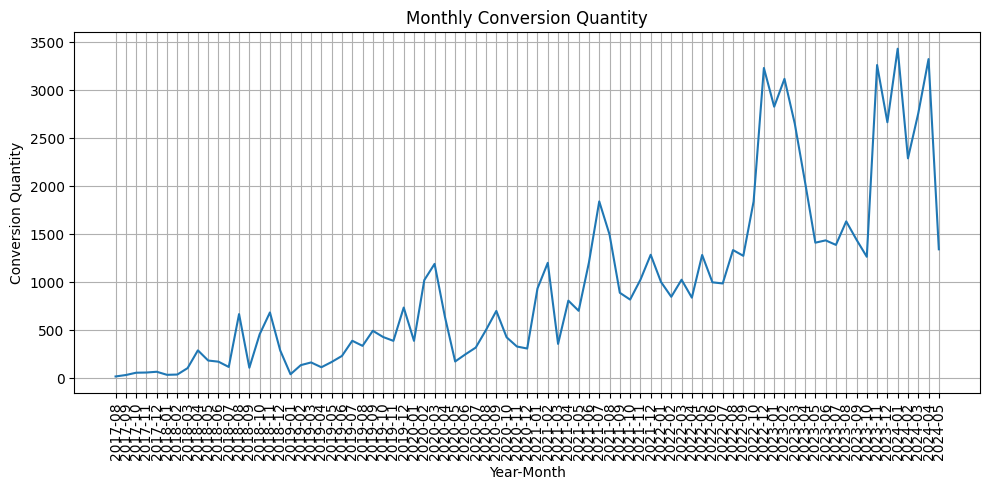

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['y'])  # Convert year_month to string for plotting
plt.title('Monthly Conversion Quantity')
plt.xlabel('Year-Month')
plt.ylabel('Conversion Quantity')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


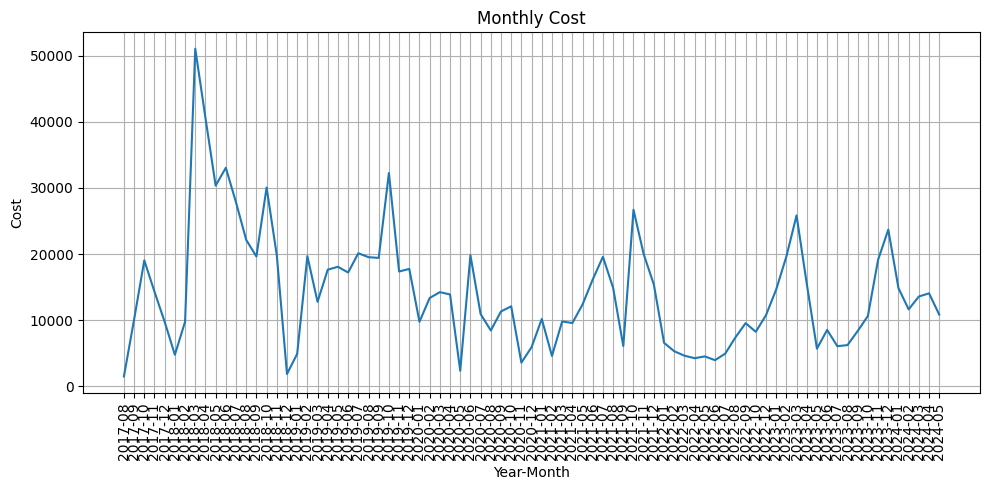

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['X'])  # Convert year_month to string for plotting
plt.title('Monthly Cost')
plt.xlabel('Year-Month')
plt.ylabel('Cost')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


/var/tmp/ipykernel_239063/4278892625.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_filtered_plot['year_month'].astype(str), rotation=90)


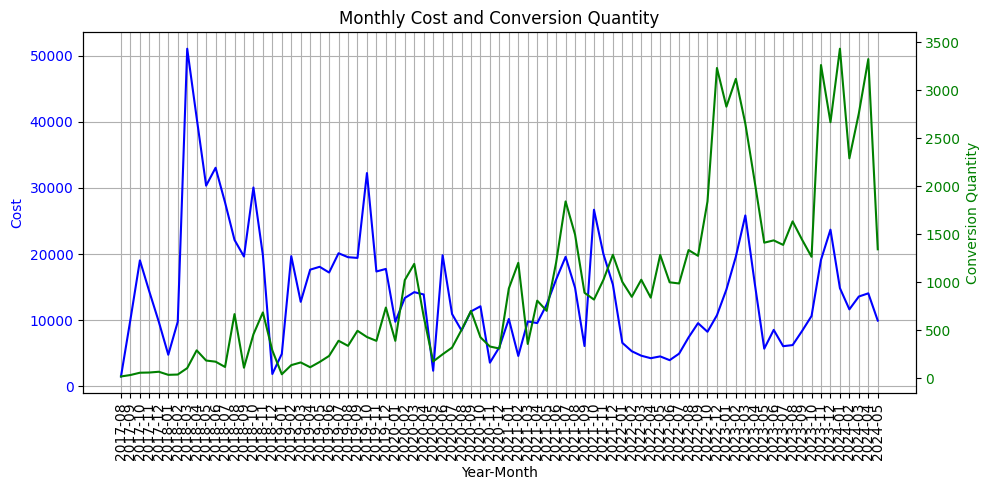

In [44]:

fig, ax1 = plt.subplots(figsize=(10, 5))


ax1.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['X'], color='b', label='Cost')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Monthly Cost and Conversion Quantity')
ax1.grid(True)
ax1.set_xticklabels(df_filtered_plot['year_month'].astype(str), rotation=90)


ax2 = ax1.twinx()
ax2.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['y'], color='g', label='Conversion Quantity')
ax2.set_ylabel('Conversion Quantity', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()


plt.show()


In [10]:
df_plot = df.loc[(df['funnel']=='Non_Brand')].copy()
df_plot['year_month'] = df_plot.ds.dt.strftime('%Y-%m')
year_2023 = df_plot.loc[(df_plot['ds'] >= '2023-10-15') & (df_plot['ds'] <= '2023-11-15'), ['market','X','y','month','day','year','funnel','ds','year_month']]
year_2023 = year_2023.groupby(['market','ds']).sum(numeric_only=True).reset_index()

In [11]:
df_plot=df_plot.groupby(['market','ds']).sum(numeric_only=True).reset_index()

/var/tmp/ipykernel_315092/3020298888.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(year_2023['ds'].astype(str), rotation=90)


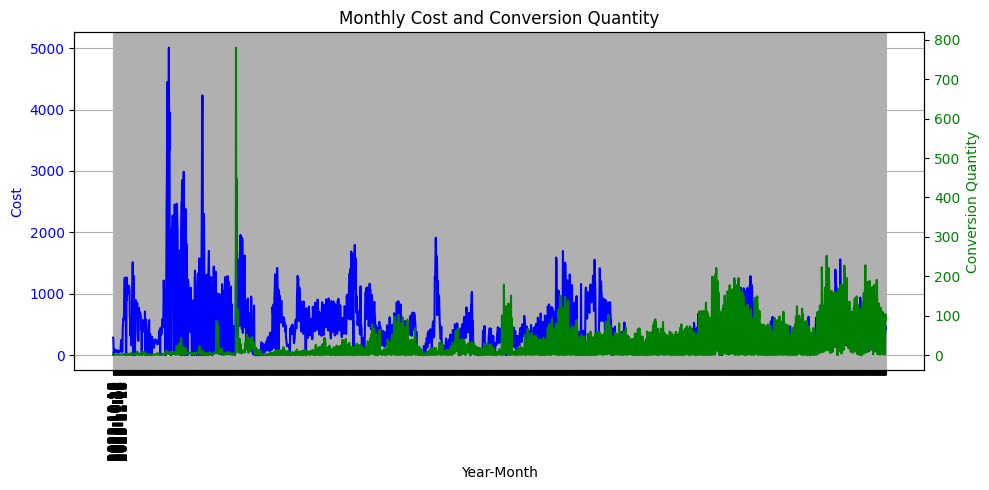

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 5))


ax1.plot(df_plot['ds'].astype(str), df_plot['X'], color='b', label='Cost')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Monthly Cost and Conversion Quantity')
ax1.grid(True)
ax1.set_xticklabels(year_2023['ds'].astype(str), rotation=90)


ax2 = ax1.twinx()
ax2.plot(df_plot['ds'].astype(str), df_plot['y'], color='g', label='Conversion Quantity')
ax2.set_ylabel('Conversion Quantity', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()


plt.show()
